### MVA Deep Learning Mini Project 1: Image Classification and Regression - Ahmed Skander KARKAR

In [10]:
import time, math, numpy as np
from keras.models import Sequential 
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, UpSampling2D
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
IMAGE_SIZE = 72

-  First, here are the functions from utils.py needed to generate the data for classification.

In [2]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]
    
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0: # changed to 100
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    print('Done.')
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

### 3. Simple Classification & 4. Visualization of the Solution

-  Below I generate the training data for classification. The function *linear_classifier()* trains and returns a model with the chosen optimizer, and also shows a visualization of its weights. The linear classifier is simply a dense layer with softmax activation. 
-  From the generating function, know that the label 1 corresponds to a disk. The output of the model on a disk image should then be close to $[0, 1, 0]$.

In [3]:
def linear_classifier(X_train, Y_train, opt, n_epochs = 10, verbose = 2, show = False, example = False) :
    model = Sequential()
    model.add(Dense(3, activation = 'softmax', input_shape = (IMAGE_SIZE ** 2, )))
    if opt == 'sgd':
        Opt = SGD(lr = 1 / 10 ** 4, decay = 1e-6, momentum = 0.9, nesterov = True)
    if opt == 'adam':
        Opt = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8, decay = 1e-6, amsgrad = False)
    model.compile(loss = 'categorical_crossentropy', optimizer = Opt, metrics = ['accuracy'])
    model.fit(X_train, Y_train, epochs = n_epochs, batch_size = 32, verbose = verbose)
    if show : # visualization of the weights
        M = model.get_weights()[0]
        print('\n' + opt + ', weight visualization:')
        plt.figure(figsize = (16, 16))
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.imshow(M[:, i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap = 'gray')
        plt.show()
    if example : # test the model on a disk image
        X_test = generate_a_disk()
        print('\ntest image:')
        plt.figure()
        plt.imshow(X_test.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap = 'gray')
        plt.show()
        X_test = X_test.reshape(1, X_test.shape[0])
        print('model output:')
        print(model.predict(X_test))
    return model

# generate dataset of centred shapes
n_train1 = 300
[X_train1, Y_train1] = generate_dataset_classification(n_train1, 20, False)
Y_train1 = np_utils.to_categorical(Y_train1, 3)

n_epochs1 = 20

Creating data:
0
100
200
Done.


-  The Adam optimizer worked very well, even without fine-tuning its parameters. 
-  The SGD optimizer needed a learning rate of $10^{-4}$ (or smaller) to converge, but performances of the adam optimizer were still better for the same number of epochs.

Epoch 1/20
 - 0s - loss: 2.5279 - acc: 0.4000
Epoch 2/20
 - 0s - loss: 1.3939 - acc: 0.5067
Epoch 3/20
 - 0s - loss: 0.8489 - acc: 0.5933
Epoch 4/20
 - 0s - loss: 0.5187 - acc: 0.7900
Epoch 5/20
 - 0s - loss: 0.4221 - acc: 0.9133
Epoch 6/20
 - 0s - loss: 0.3146 - acc: 0.9533
Epoch 7/20
 - 0s - loss: 0.2791 - acc: 0.9433
Epoch 8/20
 - 0s - loss: 0.2429 - acc: 0.9667
Epoch 9/20
 - 0s - loss: 0.2208 - acc: 0.9767
Epoch 10/20
 - 0s - loss: 0.1934 - acc: 0.9867
Epoch 11/20
 - 0s - loss: 0.1725 - acc: 0.9900
Epoch 12/20
 - 0s - loss: 0.1541 - acc: 1.0000
Epoch 13/20
 - 0s - loss: 0.1399 - acc: 1.0000
Epoch 14/20
 - 0s - loss: 0.1331 - acc: 0.9900
Epoch 15/20
 - 0s - loss: 0.1546 - acc: 0.9800
Epoch 16/20
 - 0s - loss: 0.1284 - acc: 0.9933
Epoch 17/20
 - 0s - loss: 0.1109 - acc: 1.0000
Epoch 18/20
 - 0s - loss: 0.1065 - acc: 0.9900
Epoch 19/20
 - 0s - loss: 0.0855 - acc: 1.0000
Epoch 20/20
 - 0s - loss: 0.0793 - acc: 1.0000

adam, weight visualization:


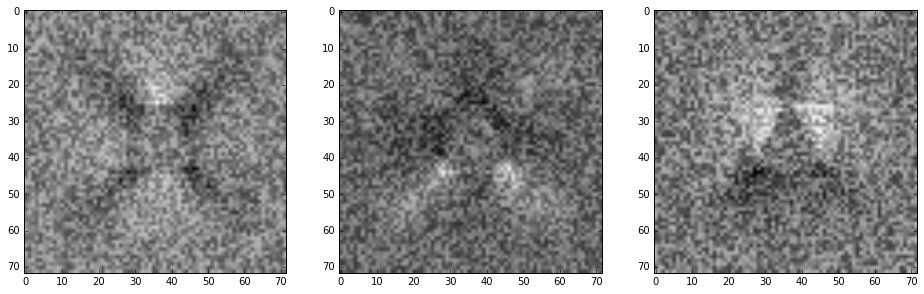


test image:


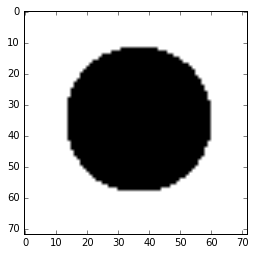

model output:
[[0. 1. 0.]]


In [4]:
lin_adam = linear_classifier(X_train1, Y_train1, 'adam', n_epochs1, 2, True, True)

Epoch 1/20
 - 0s - loss: 1.1441 - acc: 0.3733
Epoch 2/20
 - 0s - loss: 1.0394 - acc: 0.4467
Epoch 3/20
 - 0s - loss: 0.9408 - acc: 0.6000
Epoch 4/20
 - 0s - loss: 0.8755 - acc: 0.6567
Epoch 5/20
 - 0s - loss: 0.8121 - acc: 0.6767
Epoch 6/20
 - 0s - loss: 0.7570 - acc: 0.7400
Epoch 7/20
 - 0s - loss: 0.7159 - acc: 0.7467
Epoch 8/20
 - 0s - loss: 0.6793 - acc: 0.7633
Epoch 9/20
 - 0s - loss: 0.6435 - acc: 0.8200
Epoch 10/20
 - 0s - loss: 0.6237 - acc: 0.7967
Epoch 11/20
 - 0s - loss: 0.5934 - acc: 0.8367
Epoch 12/20
 - 0s - loss: 0.5742 - acc: 0.8300
Epoch 13/20
 - 0s - loss: 0.5549 - acc: 0.8367
Epoch 14/20
 - 0s - loss: 0.5382 - acc: 0.8667
Epoch 15/20
 - 0s - loss: 0.5219 - acc: 0.8600
Epoch 16/20
 - 0s - loss: 0.5035 - acc: 0.9133
Epoch 17/20
 - 0s - loss: 0.4917 - acc: 0.8900
Epoch 18/20
 - 0s - loss: 0.4748 - acc: 0.9000
Epoch 19/20
 - 0s - loss: 0.4705 - acc: 0.8833
Epoch 20/20
 - 0s - loss: 0.4567 - acc: 0.8833

sgd, weight visualization:


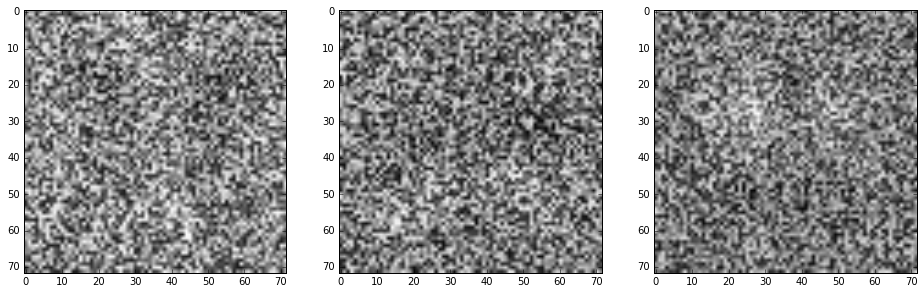


test image:


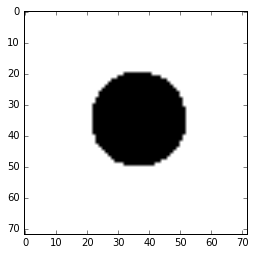

model output:
[[0. 1. 0.]]


In [5]:
lin_sgd = linear_classifier(X_train1, Y_train1, 'sgd', n_epochs1, 2, True, True)

### 5. A More Difficult Classification Problem

-  Here I generate a dataset of non-centred shapes and use it to train a linear classifier with the function defined above. After 20 epochs, the training loss is usually between 0.7 and 0.8 and the training accuracy is usually around 0.65. On the test set, the loss is slightly larger and the accuracy slightly lower.

In [6]:
n_train2 = 3000

# generate dataset of non-centred shapes
[X_train2, Y_train2] = generate_dataset_classification(n_train2, 20, True)
Y_train2 = np_utils.to_categorical(Y_train2, 3)

lin_model = linear_classifier(X_train2, Y_train2, 'adam', n_epochs1, 2, False, False)

# generate testset of non-centred shapes
[X_test, Y_test] = generate_test_set_classification()

# evaluate model
score = lin_model.evaluate(X_test, Y_test, verbose = 2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
Done.
Epoch 1/20
 - 1s - loss: 1.4323 - acc: 0.4393
Epoch 2/20
 - 0s - loss: 0.8923 - acc: 0.5597
Epoch 3/20
 - 0s - loss: 0.9481 - acc: 0.5540
Epoch 4/20
 - 0s - loss: 0.9846 - acc: 0.5430
Epoch 5/20
 - 0s - loss: 0.9011 - acc: 0.5677
Epoch 6/20
 - 0s - loss: 0.8161 - acc: 0.6000
Epoch 7/20
 - 0s - loss: 0.8292 - acc: 0.5970
Epoch 8/20
 - 0s - loss: 0.9244 - acc: 0.5800
Epoch 9/20
 - 0s - loss: 0.8203 - acc: 0.5930
Epoch 10/20
 - 0s - loss: 0.8171 - acc: 0.6147
Epoch 11/20
 - 0s - loss: 0.9031 - acc: 0.5930
Epoch 12/20
 - 0s - loss: 0.7603 - acc: 0.6150
Epoch 13/20
 - 0s - loss: 0.8508 - acc: 0.6137
Epoch 14/20
 - 0s - loss: 0.7900 - acc: 0.6220
Epoch 15/20
 - 0s - loss: 0.7732 - acc: 0.6317
Epoch 16/20
 - 0s - loss: 0.7993 - acc: 0.6170
Epoch 17/20
 - 0s - loss: 0.8186 - acc: 0.6113
Epoch 18/20
 - 0s - loss: 0.7674 - acc: 0.6353
Epoc

-  Below I use a convolutional network with the specified architecture. This model performs better than the linear classifier and achieves a very high accuracy on the training set. On the test set the loss is around 0.65 and the accuracy is between 65 and 70 percent (for a training set made of 300 samples).
-  Test accuracy improves greatly if the training dataset is larger. If $n\_train1$ is set as above to 3000 then the convolutional network achieves a test accuracy of more than 90% and a test loss of 0.24.

In [7]:
def conv_net(X_train, Y_train, n_epochs = 10, verbose = 2) :
    X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
    model = Sequential()
    model.add(Conv2D(16, (5, 5), activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    model.add(Dense(3, activation = 'softmax'))
    Opt = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8, decay = 1e-6, amsgrad = False)
    model.compile(loss = 'categorical_crossentropy', optimizer = Opt, metrics = ['accuracy'])
    model.fit(X_train, Y_train, epochs = n_epochs, batch_size = 32, verbose = verbose)
    return model

conv_model = conv_net(X_train2, Y_train2, 20)

score = conv_model.evaluate(X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1), Y_test, verbose = 2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
 - 11s - loss: 0.8610 - acc: 0.6303
Epoch 2/20
 - 11s - loss: 0.5875 - acc: 0.7737
Epoch 3/20
 - 11s - loss: 0.4933 - acc: 0.8207
Epoch 4/20
 - 11s - loss: 0.4308 - acc: 0.8527
Epoch 5/20
 - 11s - loss: 0.3744 - acc: 0.8777
Epoch 6/20
 - 11s - loss: 0.3215 - acc: 0.8853
Epoch 7/20
 - 11s - loss: 0.2632 - acc: 0.9190
Epoch 8/20
 - 11s - loss: 0.2264 - acc: 0.9283
Epoch 9/20
 - 11s - loss: 0.2031 - acc: 0.9487
Epoch 10/20
 - 11s - loss: 0.1807 - acc: 0.9507
Epoch 11/20
 - 11s - loss: 0.1500 - acc: 0.9620
Epoch 12/20
 - 11s - loss: 0.1320 - acc: 0.9697
Epoch 13/20
 - 11s - loss: 0.1210 - acc: 0.9730
Epoch 14/20
 - 11s - loss: 0.1014 - acc: 0.9777
Epoch 15/20
 - 11s - loss: 0.0853 - acc: 0.9827
Epoch 16/20
 - 12s - loss: 0.0745 - acc: 0.9873
Epoch 17/20
 - 11s - loss: 0.0702 - acc: 0.9890
Epoch 18/20
 - 11s - loss: 0.0600 - acc: 0.9927
Epoch 19/20
 - 12s - loss: 0.0516 - acc: 0.9950
Epoch 20/20
 - 13s - loss: 0.0470 - acc: 0.9960
Test loss: 0.24108452717463175
Test accuracy: 0.9

### 6. A Regression Problem

-  After testing other methods, I chose to normalize the coordinates of the triangle vertices by ordering the vertices counterclockwise. This is done by first calculating the center of the triangle (any point inside the triangle would work). Then we sort the vertices according to the angle they form with the center (and the origin). I implemented this by directly modifying the generating process and defining the function *generate_a_triangle2()* which is then called by *generate_dataset_regression()*

In [3]:
def generate_a_triangle2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
        center_u = np.mean(U)
        center_v = np.mean(V)
        angle = lambda u, v : math.degrees(math.atan2(u, v))
        W = np.array([angle(U[i] - center_u, V[i] - center_v) for i in range(3)])
        s = W.argsort()
        U = U[s]
        V = V[s]
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle2()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle2(noise, True)
    print('Done.')
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE, IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)
    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

-  I use a feed forward convolutional network with 4 convolutional layers (each followed by a maxpooling subsampling layer) and 3 fully connected layers, all (except the output layer) with relu activation. As loss I use the mean absolute error which gave better results than mean squared error.

In [4]:
%%time

# generate regression dataset
n_train3 = 6000
[X_train3, Y_train3] = generate_dataset_regression(n_train3, 20)
X_train3 = X_train3.reshape(X_train3.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

# specify model
n_epochs3 = 100
model = Sequential()
model.add(Conv2D(16, (7, 7), activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (5, 5), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (5, 5), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(6))
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8, decay = 1e-6, amsgrad = False)
model.compile(loss = 'mean_absolute_error', optimizer = adam)
model.fit(X_train3, Y_train3, epochs = n_epochs3, batch_size = 32)

# test model
[X_test3, Y_test3] = generate_test_set_regression()
X_test3 = X_test3.reshape(X_test3.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
print('test error:')
print(model.evaluate(X_test3, Y_test3, verbose = 0))


Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
Done.
Epoch 1/100
6000/6000 [==============================] - 69s 11ms/step - loss: 0.1665
Epoch 2/100
6000/6000 [==============================] - 72s 12ms/step - loss: 0.1027
Epoch 3/100
6000/6000 [==============================] - 67s 11ms/step - loss: 0.0892
Epoch 4/100
6000/6000 [==============================] - 67s 11ms/step - loss: 0.0800
Epoch 5/100
6000/6000 [==============================] - 68s 11ms/step - loss: 0.0749
Epoch 6/100
6000/6000 [==============================] - 67s 11ms/step - loss: 0.0703
Epoch 7/100
6000/6000 [==============================] - 65s 11ms/step - loss: 0.0659
Epoch 8/100
6000/6000 [==============================] - 65s 11ms/step - loss: 0.0629
Epo

-  We can see some predictions of the model on the test set.

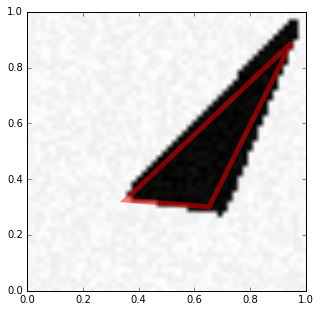

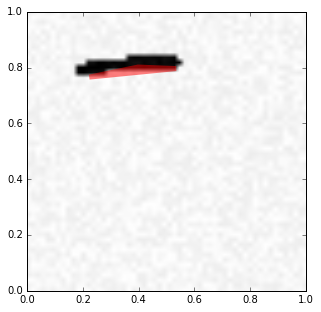

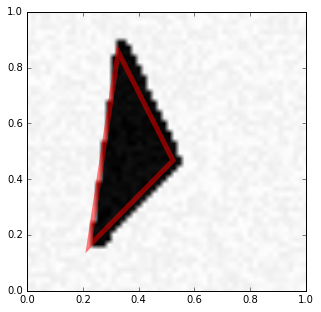

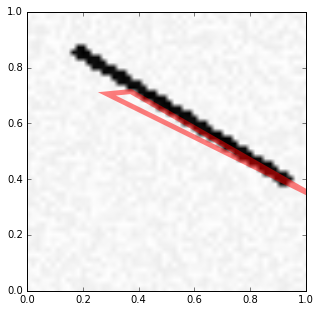

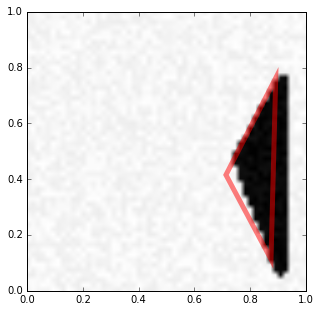

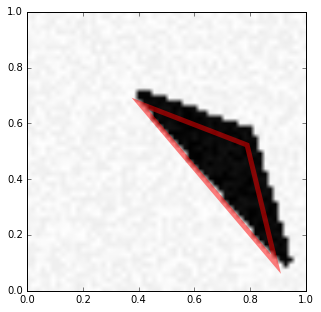

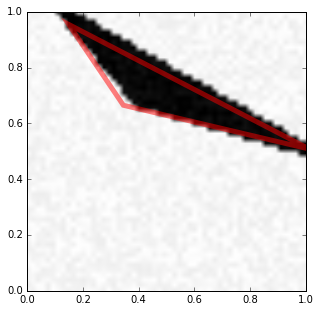

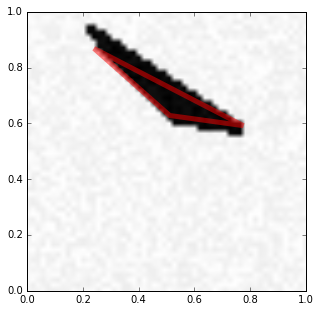

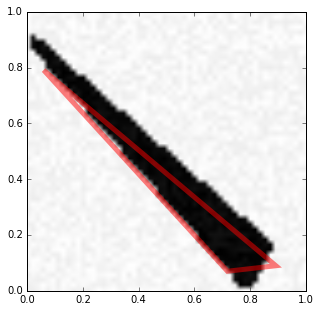

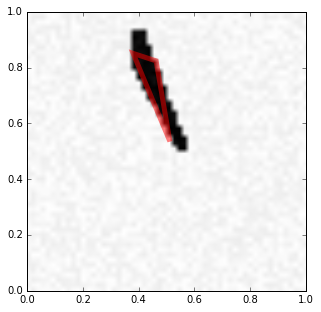

In [5]:
Y_pred3 = model.predict(X_test3)
for i in range(10):
    visualize_prediction(X_test3[i], Y_pred3[i])

-  The model needed large training sets and many epochs to give good results. This took a lot of time (on my cpu) so I couldn't experiment much more. But this way of ordering the vertices performed much better than other methods, which each had a weakness on a particular shape of triangles. 

### 7. Image Denoising

- I create below new functions *generate_a_drawing2()*, *generate_a_rectangle2()*, *generate_a_disk2()*, *generate_a_triangle2()*. Function *generate_a_drawing2()* returns an image without noise and an image with noise. The other functions simply call it. I then generate a dataset and plot an example of a pair of images.

Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
Done.


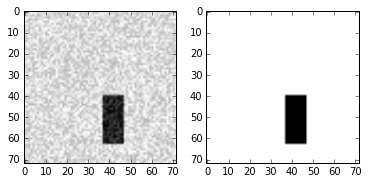

In [6]:
def generate_a_drawing2(figsize, U, V, noise = 0.0):
    fig = plt.figure(figsize = (figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata1 = np.frombuffer(fig.canvas.tostring_rgb(), dtype = np.uint8)[::3].astype(np.float32)
    imdata2 = imdata1 + noise * np.random.random(imdata1.size)
    plt.close(fig)
    return imdata2, imdata1
    
def generate_a_rectangle2(noise = 0.0, free_location = False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing2(figsize, U, V, noise)


def generate_a_disk2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing2(figsize, U, V, noise)

def generate_a_triangle2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random()) * figsize / 2
        middle = figsize / 2
        U = (middle, middle + size, middle - size)
        V = (middle + size, middle - size, middle - size)
    return generate_a_drawing2(figsize, U, V, noise)

def generate_dataset_denoising(nb_samples, noise = 0.0, free_location = True) :
    im_size = generate_a_rectangle2()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0: 
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle2(noise, free_location)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk2(noise, free_location)
        else:
            X[i], Y[i] = generate_a_triangle2(noise, free_location)
    print('Done.')
    X = (X + noise) / (255 + 2 * noise)
    Y = (Y + noise) / (255 + 2 * noise)
    return [X, Y]
    
def generate_test_set_denoising(noise = 20):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(300, noise)
    return [X_test, Y_test]

n_train4 = 6000
noise = 100
[X_train4, Y_train4] = generate_dataset_denoising(n_train4, noise)
X_train4 = X_train4.reshape(X_train4.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
Y_train4 = Y_train4.reshape(Y_train4.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(X_train4[0].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(Y_train4[0].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap = 'gray')
plt.show()

-  I use the following hourglass network (denoising autoencoder).

In [7]:
%%time

n_epochs4 = 50
denoiser = Sequential()
denoiser.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)))
denoiser.add(MaxPooling2D((2, 2), padding = 'same'))
denoiser.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
denoiser.add(MaxPooling2D((2, 2), padding = 'same'))
denoiser.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
denoiser.add(UpSampling2D((2, 2)))
denoiser.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
denoiser.add(UpSampling2D((2, 2)))
denoiser.add(Conv2D(1, (3, 3), padding = 'same'))
denoiser.compile(optimizer = 'adam', loss = 'mse')
denoiser.fit(X_train4, Y_train4, epochs = n_epochs4, batch_size = 32)

Epoch 1/50
6000/6000 [==============================] - 74s 12ms/step - loss: 0.0228
Epoch 2/50
6000/6000 [==============================] - 71s 12ms/step - loss: 0.0023
Epoch 3/50
6000/6000 [==============================] - 72s 12ms/step - loss: 0.0015
Epoch 4/50
6000/6000 [==============================] - 72s 12ms/step - loss: 0.0013
Epoch 5/50
6000/6000 [==============================] - 72s 12ms/step - loss: 0.0011
Epoch 6/50
6000/6000 [==============================] - 72s 12ms/step - loss: 0.0010
Epoch 7/50
6000/6000 [==============================] - 72s 12ms/step - loss: 9.2468e-04
Epoch 8/50
6000/6000 [==============================] - 73s 12ms/step - loss: 8.6450e-04
Epoch 9/50
6000/6000 [==============================] - 73s 12ms/step - loss: 8.1618e-04
Epoch 10/50
6000/6000 [==============================] - 73s 12ms/step - loss: 7.8030e-04
Epoch 11/50
6000/6000 [==============================] - 72s 12ms/step - loss: 7.4710e-04
Epoch 12/50
6000/6000 [====================

-  We can now test the model on a test set

Creating data:
0
100
200
Done.
test loss:
0.0003920941272129615


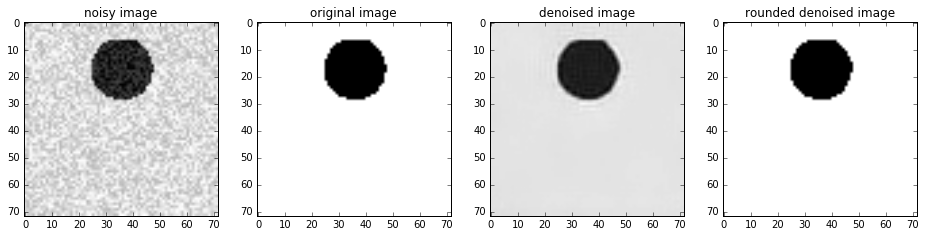

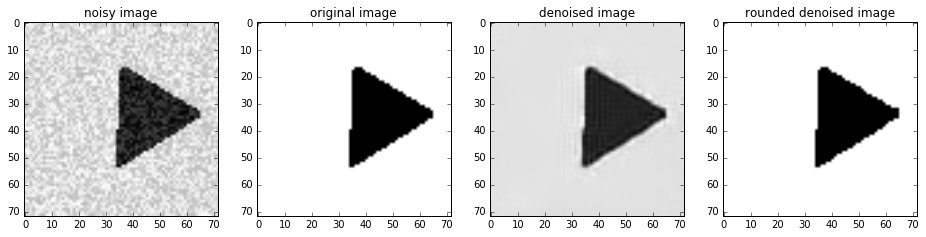

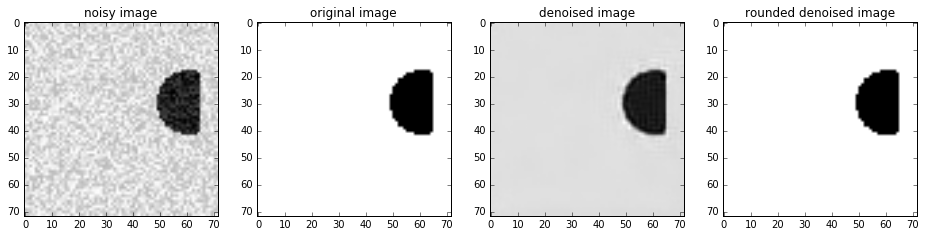

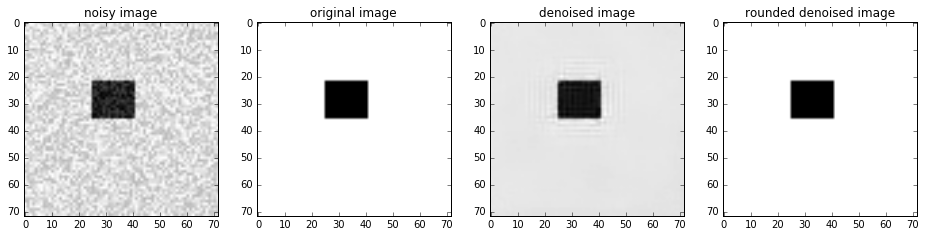

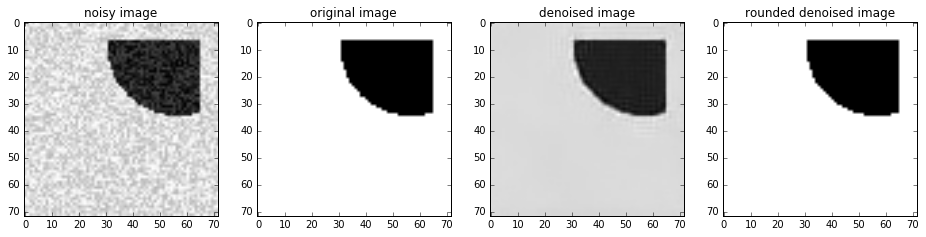

In [11]:
[X_test4, Y_test4] = generate_test_set_denoising(noise)
X_test4 = X_test4.reshape(X_test4.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
Y_test4 = Y_test4.reshape(Y_test4.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

def test_denoiser(denoiser, X_test, Y_test):
    print('test loss:')
    print(denoiser.evaluate(X_test, Y_test, verbose = 0))
    Y_pred = denoiser.predict(X_test)
    Z_pred = np.round(Y_pred)
    for i in range(5):
        plt.figure(figsize = (16, 16))
        plt.subplot(1, 4, 1)
        plt.title('noisy image')
        plt.imshow(X_test[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap = 'gray')
        plt.subplot(1, 4, 2)
        plt.title('original image')
        plt.imshow(Y_test[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap = 'gray')
        plt.subplot(1, 4, 3)
        plt.title('denoised image')
        plt.imshow(Y_pred[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap = 'gray')
        plt.subplot(1, 4, 4)
        plt.title('rounded denoised image')
        plt.imshow(Z_pred[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap = 'gray')
        plt.show()
        
test_denoiser(denoiser, X_test4, Y_test4)

-  The network eliminates the noise very well. In this particular case, since we now that the original image is made of pixels that are either black or white, the output of the network can be rounded up to 1 or down to 0. The final output after this operation is almost identical to the original image.
-  Below I show that a network of this architecture also works when the images (training and test) have different levels of noise (i.e random amplitude). The maximal level of noise is also higher.

Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
Done.
Epoch 1/70
7000/7000 [==============================] - 88s 13ms/step - loss: 0.0162
Epoch 2/70
7000/7000 [==============================] - 85s 12ms/step - loss: 0.0013
Epoch 3/70
7000/7000 [==============================] - 85s 12ms/step - loss: 9.4622e-04
Epoch 4/70
7000/7000 [==============================] - 85s 12ms/step - loss: 7.4351e-04
Epoch 5/70
7000/7000 [==============================] - 87s 12ms/step - loss: 6.3973e-04
Epoch 6/70
7000/7000 [==============================] - 88s 13ms/step - loss: 5.9024e-04
Epoch 7/70
7000/7000 [==============================] - 91s 13ms/step - loss: 5.5338e-04
Epoch 8/70
7000/7000 [====

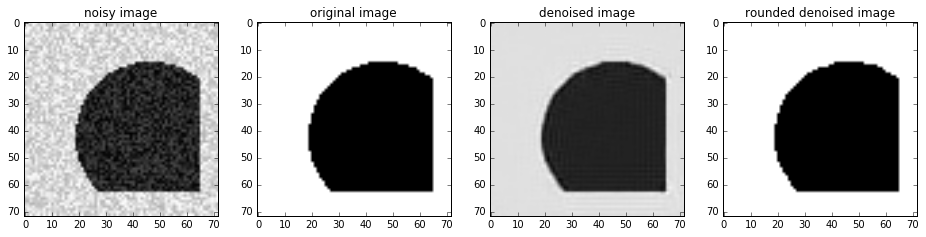

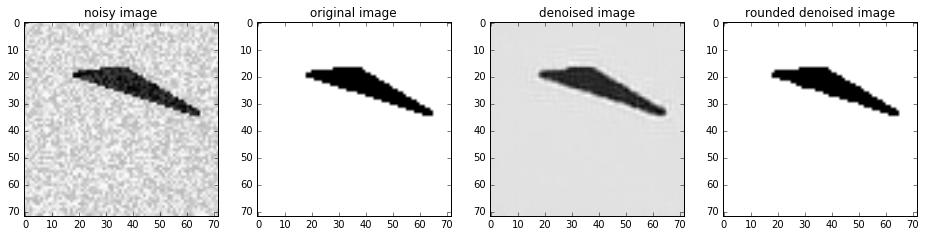

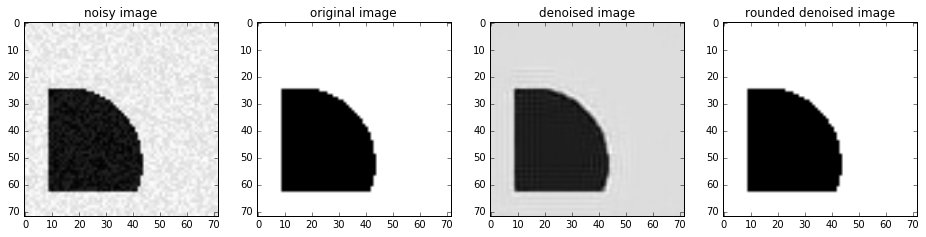

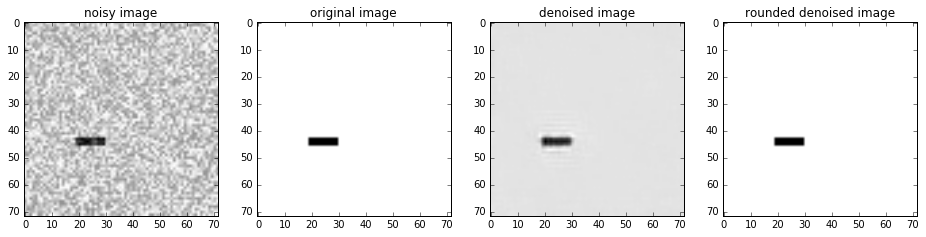

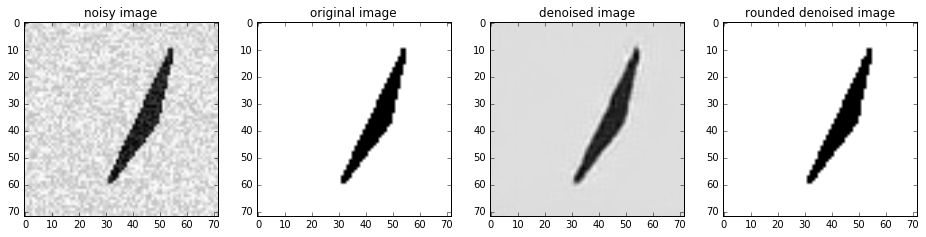

CPU times: user 4h 30min 50s, sys: 1h 5min 35s, total: 5h 36min 26s
Wall time: 1h 54min 35s


In [13]:
%%time

def generate_dataset_denoising2(nb_samples, noise = 0.0, free_location = True) :
    im_size = generate_a_rectangle2()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0: 
            print(i)
        category = np.random.randint(3)
        noise_amp = np.random.randint(noise) # random amplitude
        if category == 0:
            X[i], Y[i] = generate_a_rectangle2(noise_amp, free_location)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk2(noise_amp, free_location)
        else:
            X[i], Y[i] = generate_a_triangle2(noise_amp, free_location)
    print('Done.')
    X = (X + noise) / (255 + 2 * noise)
    Y = (Y + noise) / (255 + 2 * noise)
    return [X, Y]
    
def generate_test_set_denoising2(noise = 20):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising2(300, noise)
    return [X_test, Y_test]

n_train5 = 7000
noise2 = 200
[X_train5, Y_train5] = generate_dataset_denoising2(n_train5, noise2)
X_train5 = X_train5.reshape(X_train5.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
Y_train5 = Y_train5.reshape(Y_train5.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
n_epochs5 = 70

denoiser2 = Sequential()
denoiser2.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)))
denoiser2.add(MaxPooling2D((2, 2), padding = 'same'))
denoiser2.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
denoiser2.add(MaxPooling2D((2, 2), padding = 'same'))
denoiser2.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
denoiser2.add(UpSampling2D((2, 2)))
denoiser2.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
denoiser2.add(UpSampling2D((2, 2)))
denoiser2.add(Conv2D(1, (3, 3), padding = 'same'))
denoiser2.compile(optimizer = 'adam', loss = 'mse')
denoiser2.fit(X_train5, Y_train5, epochs = n_epochs5, batch_size = 32)

[X_test5, Y_test5] = generate_test_set_denoising2(noise2)
X_test5 = X_test5.reshape(X_test5.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
Y_test5 = Y_test5.reshape(Y_test5.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

test_denoiser(denoiser2, X_test5, Y_test5)